# Variational Quantum Eigensolver

This method allows us to approximate the lowest eigenvalue of a Hamiltonian.

This is done by optimizing the parameters of a specific quantum circuit to obtain the minimum energy.

It is particulary useful because it is quite robust to noise and doesn't require many qubits, so it can be implemented in current devices. And finding the eigenvalues has several applications in chemestry and material science.

As an example, lets take the following matrix.
$$
\begin{pmatrix}
    1 & 0 & 0 & 0 \\
    0 & 0 & -1 & 0 \\
    0 & -1 & 0 & 0 \\
    0 & 0 & 0 & 1
\end{pmatrix}
$$

First, we import the requires libraries. `QuantumCircuit` is exactly what is sounds like.
`Aer` and `execute` are used to run the quantum circuits.

`I, X, Y` and `Z` are the [Pauli gates](https://qiskit.org/textbook/ch-states/single-qubit-gates.html#pauli).
These are a set of $2\times 2$ matrices with very useful propetrties.
They will be used to transform the given matrix into a form that is encodable into quantum circuits.

Finally, `numpy` and `matplotlib` will be used to manage matrices and to create plots.

In [1]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.aqua.operators import I, X, Y, Z
import numpy as np
from matplotlib import pyplot as plt

Then, we define the matrix.

In [2]:
H = np.array([
    [1, 0, 0, 0], 
    [0, 0, -1, 0],
    [0, -1, 0, 0], 
    [0, 0, 0, 1]
])
H

array([[ 1,  0,  0,  0],
       [ 0,  0, -1,  0],
       [ 0, -1,  0,  0],
       [ 0,  0,  0,  1]])

Now, the next step is to find the Pauli decomposition of the matrix.

## Pauli decomposition

To encode the given Hamiltonian as some optimizable circuits, it must expressed as a sum of Pauli terms.
A Pauli term is the product of Pauli gates.

How do we do that?

A first useful observation is that Pauli gates are a basis for the $2\times 2$ matrices.
While not obvious, the tensor product of basis is a basis.
So the set of all Pauli terms of $n$ gates is a basis for the $2^n \times 2^n$ matrices.

Then, every matrix $H$ can be represented as a linear combination of Pauli terms.

In other words, if $P_i$ is a Pauli term, the following equation always has solution

$$
H = c_1 P_1 + \dots + c_{2^n} P_{2^n} =
\begin{pmatrix}
    P_1 & \dots & P_{2^n}
\end{pmatrix}
\begin{pmatrix}
    c_1 \\
    \vdots \\
    c_{2^n}
\end{pmatrix}
= \mathcal{P}\vec{c}
$$

$\mathcal{P}$ is a matrix of matrices. This can be defined because the space of matrices is also a vector space.
In practice, we just need to find a representation of each matrix as a vector.
The easiest way would be to 'flatten' each matrix into a vector.

That is, the position $i, j$ of a $n \times m$ matrix is mapped to the $ni+j$ position of a $mn$-dimentional vector.

To implement this, we first generate the Pauli basis. This is very straight forward. We just need to make the tensor product of all combinations of $n$ Pauli gates.

_Note_: In `qiskit`, the tensor product is represented as `^`.

In [3]:
def pauli_basis(n):
    from itertools import product
    from functools import reduce
    
    basis1 = [I, X, Y, Z]
    
    basis_n_lists = product([g for g in basis1], repeat=n)
    
    basis_n = [reduce(lambda g, h: g^h, l) for l in basis_n_lists]

    return basis_n

Then, we solve the equation using `numpy`. `numpy` requieres $\mathcal{P}$ as a matrix and $H$ as a vector.
As explained before, we do this by 'flattening' the matrices.

In [4]:
def basis_change_matrix(M):
    M_t = np.vstack(tuple(g.flatten() for g in M)) # we flatten the matrices and we stack them in a new matrix
    return M_t.T

def to_pauli_op(A):
    from math import log2
    
    # making sure the matrix can be decomposed
    n = log2(len(A)) 
    m, k = A.shape
    if not n.is_integer() or m != k:
        raise ValueError('Pauli decomposition is only possible for 2^n x 2^n matrices')
    
    basis_ops = pauli_basis(int(n)) # we compute the basis
    
    M = basis_change_matrix([op.to_matrix() for op in basis_ops]) # we find \mathcal{P}
    
    coeffs = np.linalg.solve(M, A.flatten()) # we calculate \vec{c}
    
    # and we build the linear combination
    d = [c * op for c, op in zip(coeffs, basis_ops) if c != 0] 

    return sum(d)

Then, we calculate the Pauli decomposition of the example matrix 

In [5]:
Hop = to_pauli_op(H)
print(Hop)

SummedOp([
  (0.5+0j) * II,
  (-0.5+0j) * XX,
  (-0.5-0j) * YY,
  (0.5+0j) * ZZ
])


## Circuit encoding

Now, why it is useful to have the Pauli decomposition?

Beacause if we can minimize the Pauli terms, minimizing their sum can be done with any classical optimization method.

To do this, lets first focus on one qubit operators.

### Operators on one qubit

For the identity, $\langle \psi | I | \psi \rangle = \langle \psi | \psi \rangle = \|\psi\|^2=1$.
So the expectation value is always 1 and it is not necessary to estimate it with a quantum circuit.

Then lets focus on the $Z$ gate. It has eigenstates $|0\rangle, |1\rangle$ with corresponding $1, -1$ eigenvalues.

So to find the expected energy of a qubit $Z|\psi\rangle$, we would have to average all the measurements, where each $|0\rangle$ has energy 1 and each $|1\rangle$ energy -1.

However, most current devices only allow measurements in the computational basis $|0\rangle, |1\rangle$. Then, what can we do about operators with eigenstates different from the omputational basis?

We just have to change the basis at the end, just before the measurements.

That is, if $|s_0\rangle, |s_1\rangle$ are the eigenstates, we have to find an operator $C$ such that

$$
    C|s_0\rangle = |0\rangle \\
    C|s_1\rangle = |1\rangle \\
$$

For $Y$ and $X$, this process is not hard, but it is a little bit long. A detailed derivation can be found [here](https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb).

Suffice to say, the operators are

$$
C_X = \frac{1}{\sqrt{2}}\begin{pmatrix}
    1 & 1 \\
    1 & -1
\end{pmatrix} \quad
C_Y = \frac{1}{\sqrt{2}}\begin{pmatrix}
    1 & -i \\
    1 & i
\end{pmatrix}
$$

### Operators on more than one qubit

The eigenstates of $A \otimes B$ are all the posible tenson products of eigenstates of $A$ and eigenstates of $B$.
In the same manner, the eigenvalues are just the product of the eigenvalues.

As $A \otimes B$ acts independenly on each qubit, then is is enough to follow the treat each Pauli gate in the term as described above. 

In [6]:
def rot_measure(qc, term):
    label = term.primitive.to_label() # is there a better way to iterate through the tensor product terms? maybe, but i didn't find it
    for i, g in enumerate(label):
        {
            'I': lambda: None, # we can ignore the gate if it appears in the tensor product
            # we use the U2 gate to implement C_X and C_Y
            'X': lambda: qc.u2(0, np.pi, i),
            'Y': lambda: qc.u2(0, np.pi/2, i),
            'Z': lambda: None
        }[g]()
        
def state_to_value(state):
    # we get the eigenvalues of a given eigenstate (in the computational basis)
    v = 1
    for s in state:
        v *= 1 if s=='0' else -1
    return v

For example, the rotation to measure $XY$ would be

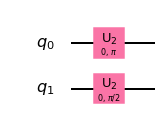

In [7]:
qxy = QuantumCircuit(2)
rot_measure(qxy, X^Y)
qxy.draw(output='mpl')

$I^{\otimes n}$ still has expected value 1. So it has to be processed separately.
In this function, we return the given hamiltonian with out the $I^{\otimes n}$ term and the coefficient of that term.

In [8]:
def process_I(Hop):
    In = I^Hop.num_qubits
    
    ops = []
    eI = 0
    for op in Hop:
        if op.primitive == In.primitive:
            eI = op.coeff
        else:
            ops.append(op)
    return eI, sum(ops) 

## Variational form

We can get the expeted energy for a qubit. How do we get the minimum?

Searching through all possible qubits is inefficient. We have to restricti our search to a domain that we suspect has the minimum.

To do this, we use variational forms. These are quantum circuits where some values are parametrized.

Finding an appropiate variational form is hard problem in the field of Quantum Machine Learning.

In this case, we use the following

$$
    (R_X(\theta) \otimes I) CNOT (H\otimes I)
$$

Here, $R_X$ represents a rotations in the $X$ axis by an angle $\theta$. This will be our only parameter.

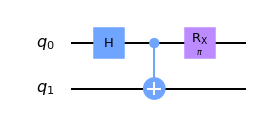

In [9]:
def ansatz(qc, params):
    qc.h(0)
    qc.cx(0, 1)
    qc.rx(params[0], 0)
    
qanz = QuantumCircuit(2)
ansatz(qanz, [np.pi])
qanz.draw(output='mpl')

## Putting everything together

For a trial set of parameters, we mesh together the variational form, the rotation mesurements for each term and measure the qubits.
 
Then, we execute all the circuits a given number of times to estimate their expected energy.
We multiply this by the coefficient of the term in the decomposition, and we sum all.

The result is the spected value for the given parameters.

Then, we could use any classical technique to optimize the given parameters.

In [10]:
def term_circuit(term, params, varform=ansatz):
    qc = QuantumCircuit(term.num_qubits)

    varform(qc, params)
    qc.barrier()

    rot_measure(qc, term)
    qc.measure_all()

    return qc

def energy(Hop, varform, params, shots):
    e, Hs = process_I(Hop) # processing I independently
    
    circuits = [term_circuit(op, params, varform) for op in Hop] # creating circuits for each term
    
    for op, qc in zip(Hop, circuits):
        job = execute(qc, Aer.get_backend('qasm_simulator'), shots=shots)
        counts = job.result().get_counts()
        
        e_i = 0
        for state, freq in counts.items():
            # multiplying the normalized frecuency by the eigenvalue
            e_i += state_to_value(state) * freq / shots 

        # multiplying the energy of the circuit by the term coefficient and adding it to the total energy
        e += op.coeff * e_i 
    return e

For example, the full circuit to measure $XY$ with an $X$ rotation of $\pi$ would be

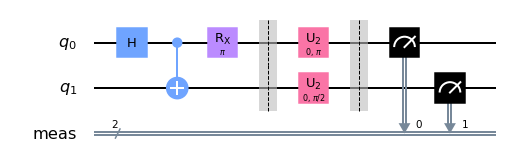

In [11]:
qxy_full = term_circuit(X^Y, [np.pi])
qxy_full.draw(output='mpl')

As we only have one parameter, the different energy states can visualized in a $2d$-plot.

So instead of using a classical optimization technique, we can plot the whole energy spectrum.

Naturally, this wouldn't be practical in a real example.

In [12]:
def vqe(Hop, varform=ansatz, shots=1000, steps=1000):
    es = []
    for i in range(steps):
        t = 2*np.pi*i/steps
        e = energy(Hop, varform, [t], shots)
        es.append(e)
        
    return es

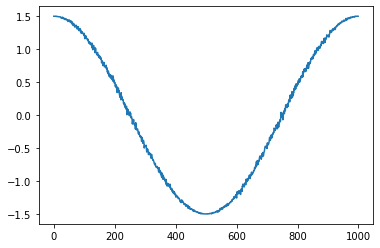

In [13]:
es = [e.real for e in vqe(Hop)]
plt.plot(es)

Finally, how off were we in the estimation?

`qiskit` exposes an exact eingensolver using numpy. We can calculate the real value of our hamiltonian very easily.

In [14]:
from qiskit.aqua.algorithms import NumPyEigensolver

real = NumPyEigensolver(Hop).run()

found_eig = min(es)
real_eig = min([e.real for e in real['eigenvalues']])

print('found:', found_eig)
print('real:', real_eig)
print('error', abs(found_eig-real_eig))

found: -1.5
real: -1.0000000000000002
error 0.4999999999999998


## References
* https://www.mustythoughts.com/variational-quantum-eigensolver-explained
* https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb